# Algorithme de Deutsch-Jozsa

## Introduction

Cet algorithme a vu le jour dans les années 1992. Bien qu'il puisse sembler peu utile, c'est le premier algorithme ayant prouvé que le calcul quantique présentait certains avantages par rapport aux ordinateurs classiques. Dans ce document, nous verrons comment l'implémenter.

### Mise en contexte

Le problème que nous essayons de résoudre ici est le suivant : nous avons en notre possession une fonction booléenne :

<!-- $$\makebox[\linewidth] f({x_0,x_1,x_2,...,x_n}): \rightarrow: 0:ou:1,;où:x_n:est:0:ou:1$$ -->

$$
\begin{aligned}
f({x_0,x_1,x_2,...,x_n})\: \rightarrow\: 0\:ou\:1,\;où\:x_n\:est\:0\:ou\:1
\end{aligned}
$$

Notre objectif est de déterminer si cette fonction est constante ou équilibrée. Une fonction constante renvoie toujours la même valeur (0 ou 1) quelles que soient les valeurs d'entrée. En revanche, une fonction équilibrée renvoie 0 pour la moitié des combinaisons possibles d'entrées et 1 pour l'autre moitié. Nous tentons donc de résoudre ce problème en utilisant cet algorithme.

### Résolution classique

Dans le meilleur scénario, nous n'aurions besoin que de deux requêtes à l'oracle. Si nous obtenons successivement un 0 suivi d'un 1, nous savons alors que l'oracle n'est pas constante et donc qu'elle est équilibrée.

Dans le pire des cas, lorsque nous avons $2^n$ entrées possibles et que nous obtenons toujours la même réponse, nous devons alors tester $2^{n-1} + 1$ entrées pour être certain que nous avons une fonction constante. Nous devons tester une entrée supplémentaire, car même si la probabilité est faible, il est possible que la première moitié des données d'entrée donne la même réponse, tandis que l'autre moitié donne la réponse inverse. C'est pourquoi nous devons tester une solution de plus que la moitié.

## Code

Ici, nous importons les outils nécessaires pour créer l'algorithme.

In [2]:
import Pkg
Pkg.add(url="https://github.com/JuliaStats/StatsBase.jl",rev="bd4ca61f4bb75f2c6cd0a47aee1cfde7b696eb9c");
Pkg.add("Plots");
using Snowflake
using SnowflakePlots
using LinearAlgebra

In [19]:
import SnowflakePlots: plot_histogram
using StatsBase
using Plots

function plot_histogram(circuit::QuantumCircuit, shots_count::Int, selected_qubits::Vector{Int})
    rawdata = simulate_shots(circuit, shots_count)

    data = String[]
    for result in rawdata
        label = String[]
        for qubit in selected_qubits
            push!(label, string(result[qubit]))
        end
        push!(data, join(label))
    end
    datamap = proportionmap(data)

    labels = String[]
    for (key, value) in datamap
        push!(labels, key)
    end
    sort!(labels)

    Plots.bar(
        (x -> datamap[x]).(labels),
        xticks = (1:length(data), labels),
        legends = false,
        ylabel = "probabilities",
    )
end

plot_histogram (generic function with 2 methods)

Pour cet exemple, nous aurons besoin d'un circuit à 4 qubits. Nous pouvons définir la variable **nb_qubits** à 4 et créer le circuit correspondant en utilisant la fonction **QuantumCircuit(qubit_count=nb_qubits)**:

In [3]:
nb_qubits = 4
circuit = QuantumCircuit(qubit_count = nb_qubits)

Quantum Circuit Object:
   qubit_count: 4 
q[1]:
     
q[2]:
     
q[3]:
     
q[4]:
     



Dans cet exemple, nous souhaitons tester toutes les possibilités en même temps avec une probabilité uniforme. Pour cela, nous devons appliquer une porte d'Hadamard à chaque qubit. Cependant, nous ne voyons pas l'application d'une porte Hadamard sur le dernier qubit. Ce dernier qubit est utilisé pour l'effet de retour de phase (Phase-Kickback). Cet effet est crucial dans cet algorithme car il nous permet de réduire le nombre d'opérations nécessaires. Le retour de phase va appliquer un signe négatif (-) à la moitié des qubits d'entrée. Pour ce faire nous devons mettre le dernier qubit dans un état $\ket-$

In [4]:
for i in 1:nb_qubits-1
    push!(circuit, hadamard(i)) # Applique une porte d'hadamard sur chaque qubit
end
# Ces deux opérations permette de mettre le dernier qubit dans l'état |->
push!(circuit, sigma_x(nb_qubits)) # Applique une porte Pauli-X sur le dernier qubit
push!(circuit, hadamard(nb_qubits)) # Applique une porte d'hadamard sur le dernier qubit

Quantum Circuit Object:
   qubit_count: 4 
q[1]:──H──────────────────────
                              
q[2]:───────H─────────────────
                              
q[3]:────────────H────────────
                              
q[4]:─────────────────X────H──
                              



À cette étape, nous effectuons l'encodage de nos valeurs d'entrée. Pour ce faire, nous pouvons définir la variable valeurentre comme étant la chaîne de bits représentant les valeurs d'entrée. Ensuite, comme nous l'avons mentionné précédemment, la porte Pauli-X nous permet de réaliser une inversion de bit, c'est-à-dire de passer d'une valeur 1 à une valeur 0, ou vice versa. Ainsi, nous appliquons une porte Pauli-X à chaque qubit correspondant à un "1" dans la chaîne de bits valeurentre.

In [5]:
valeurentre = "101" # On défini la chaine de caractère qui représente la valeur d'entrée
for i in 1:length(valeurentre)
    if valeurentre[i] == '1' 
        push!(circuit, sigma_x(i)) # On applique la porte Pauli-X si le bit est égal à 1
    end
end

Par la suite, nous créons l'oracle, qui représente la fonction booléenne pour ce problème. Dans cet exemple, nous allons créer un oracle qui retourne une fonction équilibrée. Pour ce faire, nous devons appliquer des portes CNOT (Controlled-NOT) sur chaque paire de qubits, où le qubit de contrôle est l'un des trois premiers qubits, et le qubit contrôlé est le qubit du retour de phase (le dernier qubit).

In [6]:
for i in 1:nb_qubits-1
    push!(circuit, control_x(i, nb_qubits)) # On applique une porte de contrôle sur chaque qubit
end

Pour terminer, il nous reste simplement à inverser le circuit. Comme vous le savez, les circuits quantiques sont réversibles. Pour obtenir la réponse, il suffit d'inverser le circuit, à l'exception du dernier qubit.

In [7]:
for i in 1:length(valeurentre)
    if valeurentre[i] == '1'
        push!(circuit, sigma_x(i))
    end
end

In [8]:
for i in 1:nb_qubits-1
    push!(circuit, hadamard(i))
end

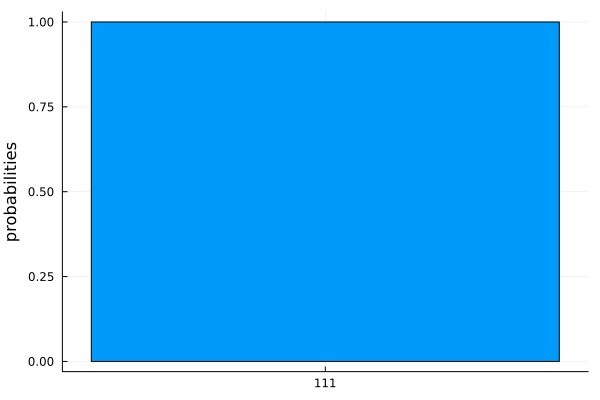

In [22]:
ψ = simulate(circuit)
plot_histogram(circuit, 100, [1,2,3])

En effet, si après avoir inversé le circuit, nous n'obtenons pas simplement l'état de base |000⟩, cela signifie que nous sommes effectivement confrontés à une fonction équilibrée.

Lorsque nous obtenons un état différent de |000⟩ après l'inversion du circuit, cela indique que notre fonction booléenne a renvoyé des sorties différentes pour différentes combinaisons d'entrées, ce qui confirme qu'elle est équilibrée.

In [10]:
println(circuit)

Quantum Circuit Object:
   qubit_count: 4 
Part 1 of 2
q[1]:──H────────────────────────X─────────*──────────────X─────────H──
                                          |                           
q[2]:───────H─────────────────────────────|────*──────────────────────
                                          |    |                      
q[3]:────────────H───────────────────X────|────|────*─────────X───────
                                          |    |    |                 
q[4]:─────────────────X────H──────────────X────X────X─────────────────
                                                                      

Part 2 of 2
q[1]:──────────
               
q[2]:──H───────
               
q[3]:───────H──
               
q[4]:──────────
               




## Code complet

In [11]:
nb_qubits = 4
valeurentre = "101" # On défini la chaine de caractère qui représente la valeur d'entrée

circuit = QuantumCircuit(qubit_count = nb_qubits)

for i in 1:nb_qubits-1
    push!(circuit, hadamard(i)) # Applique une porte d'hadamard sur chaque qubit
end
# Ces deux opérations permette de mettre le dernier qubit dans l'état |->
push!(circuit, sigma_x(nb_qubits)) # Applique une porte Pauli-X sur le dernier qubit
push!(circuit, hadamard(nb_qubits)) # Applique une porte d'hadamard sur le dernier qubit

# On encode le nombre 101 dans le circuit
for i in 1:length(valeurentre)
    if valeurentre[i] == '1' 
        push!(circuit, sigma_x(i)) # On applique la porte Pauli-X si le bit est égal à 1
    end
end

# On crée l'oracle
for i in 1:nb_qubits-1
    push!(circuit, control_x(i, nb_qubits)) # On applique une porte de contrôle sur chaque qubit
end

# On inverse le circuit d'encodage
for i in 1:length(valeurentre)
    if valeurentre[i] == '1'
        push!(circuit, sigma_x(i))
    end
end

# On applique une porte d'hadamard sur chaque qubit
for i in 1:nb_qubits-1
    push!(circuit, hadamard(i))
end

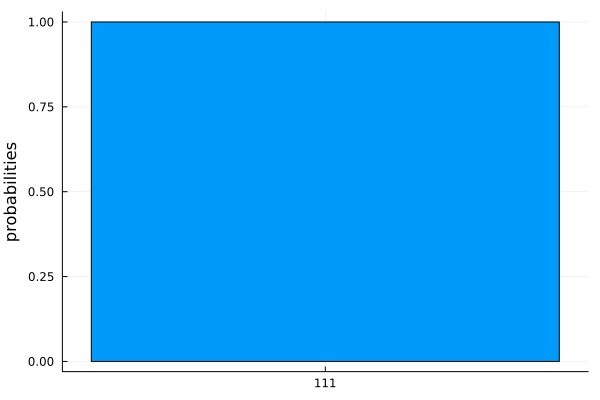

In [20]:
plot_histogram(circuit, 100, [1, 2, 3])

In [15]:
println(circuit)

Quantum Circuit Object:
   qubit_count: 4 
Part 1 of 2
q[1]:──H────────────────────────X─────────*──────────────X─────────H──
                                          |                           
q[2]:───────H─────────────────────────────|────*──────────────────────
                                          |    |                      
q[3]:────────────H───────────────────X────|────|────*─────────X───────
                                          |    |    |                 
q[4]:─────────────────X────H──────────────X────X────X─────────────────
                                                                      

Part 2 of 2
q[1]:──────────
               
q[2]:──H───────
               
q[3]:───────H──
               
q[4]:──────────
               


